
## MED 5

# Metody ograniczenia wariancji modelu

Poszukując modelu regresji czy klasyfikacji staramy się, by powstały estymator posiadał porządane statystycznie cechy: był zgodny, nieobciążony i najbardziej efektywny. W rzeczywistości trudno jest pogodzić dwie ostatnie własności. Przez brak obciążenia (*ang. bias*) rozumie się bowiem jak najlepsze dopasowanie do danych uczących. Przez największą efektywność rozumie się zwykle jak najmniejszy błąd estymacji dla zbioru testowego (każdego innego niż uczący) - najmniejszą wariancję modelu. Dla rzeczywistych zbiorów danych, na ogół, im mniejsze jest obciążenie, tym jest większa wariancja modelu i odwrotnie. Z uwagi jednak na fakt, iż celem dla którego powstaje model estymatora jest jak najskuteczniejsze jego działanie dla nowych danych (innych niż uczące), przy tworzeniu modelu stosuje się metody, które kosztem zwiększenia obciążenia, zmniejszają wariancję modelu. W praktyce jest to osiągane przez poszukiwanie, w procesie uczenia,  modelu na tyle prostego by właściwie odwzorować trend, niekoniecznie idealnie dopasowującego się do danych zbioru uczącego.  

Zwiększając liczbę cech modelu oraz tworząc nowe zmienne opisujące zwiększa się zwykle jego wariancja. Widać to wyraźnie w przypadku zastosowania regresji wielomianowej. Zwiększanie stopnia wielomianu opisującego trend naszych danych zwiększane zostają współczynniki stojące przy kolejnych potęgach, co pozwala na dokładne dopasowanie modelu do danych uczących, jednak kosztem zwiększenia jego wariancji. Mimo iż obciążenie modelu z punktu widzenia danych uczących spada do zera, to tracimy jego zdolności uogólnienia (błąd estymacji wartości na podstawie zbioru testowego rośnie), co oznacza przeuczenie/nadmierne dopasowanie (ang. overfitting) naszego modelu.

Sposobem na redukcję stopnia przeuczenia/nadmiernego dopasowania modelu, a zatem ograniczenia jego wariancji, w przypadku regresji wielomianowej, są techniki regularyzacji. Generalnie mamy dwie możliwości działania:

1. Redukujemy wpływ cech nieznaczących na model tj. pozostawiamy wszystkie cechy ale w modelu realny wpływ na wyjście mają jedynie cechy znaczące - działa jeśli mamy dużo cech, z których każda skorelowana jest z wyjściem (regularyzacja Tichonowa, regresja grzbietowa - ang. ridge regression).
       
2. Redukujemy liczbę cech na jeden z trzech sposobów:

    a) selekcja manualna - używamy ważniejszych cech (w przypadku unormowanych wartości atrybutów opisujących będą to cechy, przy których wartość modułu współczynnika jest najwyższa)    
    
    b) używamy algorytmu do wyboru cech modelu (metoda zachłanna - analizujemy które cechy najlepiej minimalizują sumę kwadratu błędów)
    
    c) używamy metody regularyzacji eliminującej zbędne cechy (metoda LASSO). 

Regresja grzbietowa i LASSO (Least Absolute Shrinkage and Selection Operator) to efektywne techniki zwykle stosowane do tworzenia oszczędnych modeli w obecności „dużej” liczby funkcji. Tutaj „duże” może zwykle oznaczać jedną z dwóch rzeczy:

1. Wystarczająco duży, aby zwiększyć tendencję modelu do nadmiernego dopasowania (tak niskie, jak 10 zmiennych może powodować nadmierne dopasowanie)
    
2. Wystarczająco duży, aby powodować wyzwania obliczeniowe. W przypadku nowoczesnych systemów taka sytuacja może wystąpić w przypadku milionów lub miliardów cech.

Chociaż metoda grzbietowa i Lasso mogą wydawać się bardzo do siebie  podobne, dzięki specyficznym własnościom ich praktyczne zastosowania różnią się znacznie. Działają one poprzez karanie wielkości współczynników cech oraz minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami. Kluczowa różnica polega na sposobie przypisywania kary do współczynników:

* Regresja grzbietowa (ridge regression, regularyzacja Tichonowa):
        Dokonuje normalizacji L2, tj. Dodaje karę równą kwadratowi wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma kwadratów współczynników)
* Regresja lasso:
        Dokonuje normalizacji L1, tj. Dodaje karę równoważną wartości bezwzględnej wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma wartości bezwzględnych współczynników)

„LS Obj” odnosi się do „celu najmniejszych kwadratów”, tj. Celu regresji liniowej bez regularyzacji.

**Celem tego laboratorium jest zapoznanie się z działaniem metod regularyzacji i dobru cech modelu**.


Materiały pomocnicze, lekkie (wideo) wprowadzenia do:

* [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Metody lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [i połączenie obu (elastic net)](https://www.youtube.com/watch?v=1dKRdX9bfIo)

Na początek - wczytanie bibliotek oraz wygenerowanie zbioru danych:

In [1]:
# Wczytaj bilbioteki podstawowe
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
# Wczytaj biblioteki potrzebne do zajęć
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

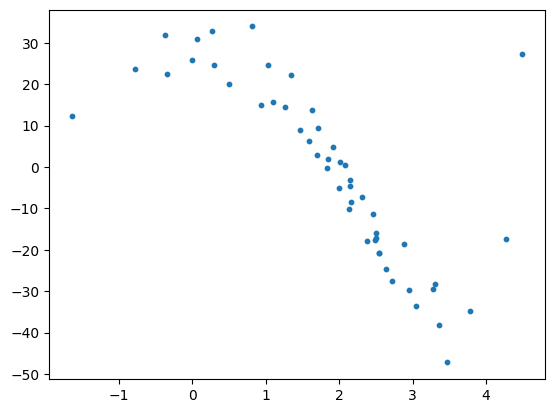

In [3]:
np.random.seed(5)
x = 2 - 3 * np.random.normal(0, 0.5, 50)
y = 30 + x - 5 * (x ** 2) - 2 * (x ** 3)+ 0.15 * (x ** 5)  + np.random.normal(-3, 5, 50)
plt.scatter(x,y, s=10)
plt.show()

### Zadanie 1 - regresja grzbietowa (ridge regression)

Zadanie polega na znalezieniu wielomianu $\hat{f}(x)$ postaci:

$$\hat{f}(x)=\omega_0+\omega_1 x^1+\omega_2x^2+ … +\omega_m x^m,$$

który mimo wysokiej złożoności modelu nie powoduje nadmiernego dopasowania do danych uczących poprzez zastosowanie regularyzacji L2.

Chcemy by nasza funkcja kosztu $J(\omega)$ miała postać:

$$J_{ridge}(\omega)=\sum_{i=0}^{n-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{\omega^2_j},$$

gdzie $i$ oznacza numer obserwacji, a $j$ kolejność współczynnika.

Wtedy rozwiązanie naszego równania wyzaczającego współczynniki wygląda w następujący sposób:

$$ \omega=\left(X^T X + \lambda \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & \ddots & 0\\ 
0 & 0 & 0  & 1 \\ 
\end{bmatrix}\right) ^{-1} X^Ty $$

**Należy pamiętać, że wyrazu wolnego nie poddajemy regularyzacji !**

A zatem - do dzieła!!!

W ramach pierwszej części zadania należy napisać funkcję wyznaczającą współczynniki $\omega$ wielomianowej funkcji regresji zgodnie z powyższym wzorem.

In [13]:
# Napisz funkcję dopasowującą model regresji wielomianowej z regularyzacją L2 
# (wykorzystując rozwiązanie równania normalnego)
def regresja_L2(x, y, lamb, stopien):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    # Macierz cech: [1, x, x^2, ..., x^stopien]
    X_poly = np.column_stack([x**k for k in range(stopien + 1)])

    # Macierz regularyzacji (bez regularyzacji wyrazu wolnego)
    L = np.eye(stopien + 1)
    L[0, 0] = 0

    # Równanie normalne z solve zamiast inv (stabilniejsze numerycznie)
    XTX = X_poly.T @ X_poly
    XTy = X_poly.T @ y
    A = XTX + lamb * L

    omega = np.linalg.solve(A, XTy)

    return omega


Poprawne (lub nie) działanie powyższej funkcji należy sprawdzić rysując jej wykres na wykresie punktowym zbioru danych

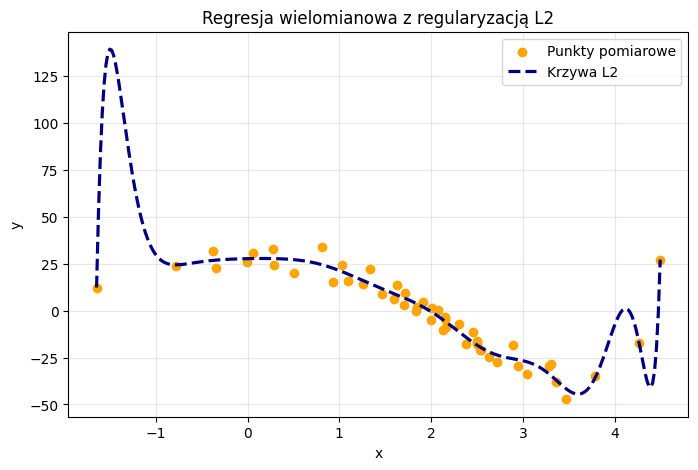

In [14]:
# Obliczenie współczynników modelu
stopien = 15
w = regresja_L2(x, y, 0.1, stopien)

# Gęsta siatka punktów
x_grid = np.linspace(np.min(x), np.max(x), 300)

# Macierz cech dla siatki i predykcja
X_grid_poly = np.column_stack([x_grid**k for k in range(len(w))])
y_pred = X_grid_poly @ w

# Wykres
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='orange', label='Punkty pomiarowe')
plt.plot(x_grid, y_pred, color='navy', linewidth=2.3, linestyle='--', label='Krzywa L2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regresja wielomianowa z regularyzacją L2')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Podobnie jak wiele innych metod uczenia maszynowego, także i metoda regresji grzbietowej została zaimplementowana w jednym z pakietów języka Python. W kolejnym kroku należy znaleźć stosowną funkcję oraz porównać wyniki jej działania z własną funkcją.

In [15]:
deg = 15

# Ta sama macierz cech co w regresja_L2
X_poly = np.column_stack([x**k for k in range(deg + 1)])

# Współczynniki z własnej funkcji
w_autorskie = regresja_L2(x, y, 0.1, deg)

# Współczynniki ze sklearn Ridge (bez własnego interceptu!)
ridge = Ridge(alpha=0.1, fit_intercept=False)
ridge.fit(X_poly, y)
w_sklearn = ridge.coef_

print("=== Zestawienie współczynników (pierwsze 5) ===")
for idx in range(5):
    print(f"k = {idx:2d} | own = {w_autorskie[idx]: .6f} | sklearn = {w_sklearn[idx]: .6f}")

srednie_odchylenie = np.mean(np.abs(w_autorskie - w_sklearn))
print("\nŚrednia różnica między wektorami wag:", f"{srednie_odchylenie:.10f}")

=== Zestawienie współczynników (pierwsze 5) ===
k =  0 | own =  27.755879 | sklearn =  27.256221
k =  1 | own =  0.956261 | sklearn =  1.108535
k =  2 | own = -2.850025 | sklearn = -1.806091
k =  3 | own =  1.248099 | sklearn =  0.555726
k =  4 | own = -5.847592 | sklearn = -6.169301

Średnia różnica między wektorami wag: 0.3120745466


C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.03987e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Celem wyznaczenia funkcji regresji na całym zbiorze, tak jak to miało miejsce powyżej, było praktyczne sprawdzenie jej działania. W przypadku, gdy uzyskany model estymatora miałby być zastosowany do estymacji wartości wyjściowej dla nieznanych wartości wejściowych (a zwykle tak to właśnie wygląda), oryginalny zbiór danych powinien zostać podzielony na zbiór uczący i testowy.

In [18]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Rozmiar zbioru treningowego: {len(X_train)}")
print(f"Rozmiar zbioru testowego: {len(X_test)}")

Rozmiar zbioru treningowego: 40
Rozmiar zbioru testowego: 10


Do oceny modelu w procesie uczenia stosuje się często walidację krzyżową. W omawianym przypadku wyróżnia się dwa parametry metody - stopień wielomianu funkcji regresji oraz parametr $\lambda$. Zwykle pierwszy z nich jest ustalany a-priori, zaś drugi podlega weryfikacji poprzez wykonanie walidacji krzyżowej estymatorów dla różnych jego wartości. 

Korzystając z walidacji krzyżowej (5-krotny wybór zbioru) na zbiorze treningowym napisz funkcję, która dla wielomianu stopnia 15 narysuje wykres średniego błędu uczenia i średniego błędu walidacji, jak również wykres przedstawiający wartości współczynników modelu w funkcji zmiany parametru regularyzacji $\lambda=[0, 0.01, 0.02, 0.04, 0.08, \cdots, 10]$. Można przyjąć, że $\lambda_{a+1}=24\lambda_a$. Można skorzystać z funkcji [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) lub [Search_Grid_CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Siatka lambd: [0.01, 0.024, 0.0576, 0.13823999999999997, 0.331776, 0.7962623999999998, 1.9110297599999997, 4.586471423999999]


C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.76492e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.76565e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.18924e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Stasd\AppD

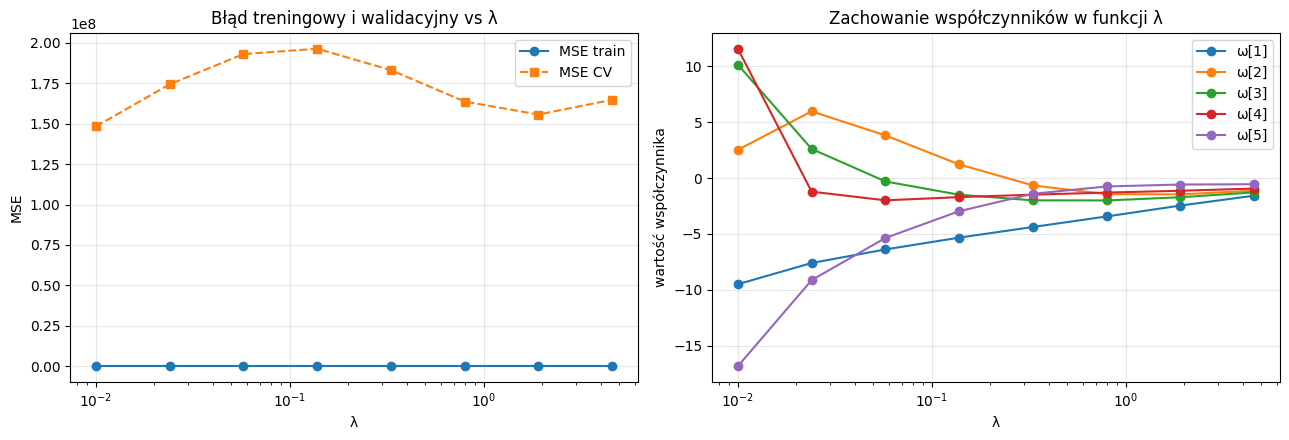


Optymalna λ: 0.01 (indeks 0)
MSE CV dla tej λ: 148283190.7347
MSE train dla tej λ: 13.6644


In [19]:
# Stopień wielomianu i macierz cech dla zbioru treningowego
deg = 15
X_tr_poly = np.vander(X_train, N=deg + 1, increasing=True)

# Wygenerowanie wartości λ: 0.01, 0.024, 0.0576, ... aż do <= 10
start_lambda = 0.01
ratio = 2.4
lambda_raw = start_lambda * (ratio ** np.arange(20))
lambda_grid = [float(val) for val in lambda_raw if val <= 10]

print("Siatka lambd:", lambda_grid)

# Listy na błędy i współczynniki
mse_train = []
mse_cv = []
coef_history = []

for alpha_val in lambda_grid:
    model = Ridge(alpha=alpha_val)

    # Błąd walidacji krzyżowej (MSE, średnia z 5-fold CV)
    cv_mse_val = -cross_val_score(
        model,
        X_tr_poly,
        y_train,
        cv=5,
        scoring="neg_mean_squared_error"
    ).mean()
    mse_cv.append(cv_mse_val)

    # Błąd na zbiorze treningowym
    model.fit(X_tr_poly, y_train)
    y_tr_hat = model.predict(X_tr_poly)
    train_mse_val = np.mean((y_train - y_tr_hat) ** 2)
    mse_train.append(train_mse_val)

    # Zapamiętaj współczynniki
    coef_history.append(model.coef_.copy())

# Konwersja listy współczynników do tablicy 2D
coef_history = np.vstack(coef_history)

# Rysowanie wykresów
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Wykres 1: MSE train vs MSE CV
axes[0].plot(lambda_grid, mse_train, marker='o', linestyle='-', label='MSE train')
axes[0].plot(lambda_grid, mse_cv, marker='s', linestyle='--', label='MSE CV')
axes[0].set_xscale('log')
axes[0].set_xlabel('λ')
axes[0].set_ylabel('MSE')
axes[0].set_title('Błąd treningowy i walidacyjny vs λ')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Wykres 2: współczynniki w funkcji λ
max_shown = min(6, deg + 1)
for j in range(1, max_shown):
    axes[1].plot(lambda_grid, coef_history[:, j], marker='o', label=f'ω[{j}]')

axes[1].set_xscale('log')
axes[1].set_xlabel('λ')
axes[1].set_ylabel('wartość współczynnika')
axes[1].set_title('Zachowanie współczynników w funkcji λ')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Wybór najlepszej λ
best_idx = int(np.argmin(mse_cv))
best_lambda = lambda_grid[best_idx]

print(f"\nOptymalna λ: {best_lambda} (indeks {best_idx})")
print(f"MSE CV dla tej λ: {mse_cv[best_idx]:.4f}")
print(f"MSE train dla tej λ: {mse_train[best_idx]:.4f}")


**Pytania:**
1. Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji $\lambda$?

Gdy zwiększamy parametr regularyzacji λ, wartości wag modelu stopniowo tracą swoją wielkość, są coraz bardziej ściągane w kierunku zera.
Przy bardzo małej regularyzacji model dopuszcza duże współczynniki, co pozwala mu dopasowywać się bardziej agresywnie do danych.
Z kolei wysokie λ mocno ogranicza swobodę modelu, dzięki czemu współczynniki stają się małe, a sam model staje się prostszy i mniej podatny na przeuczenie.

2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

Wśród sprawdzanych wartości najmniejszy błąd walidacji uzyskano dla λ = 0.01.
Oznacza to, że w tym eksperymencie ta właśnie wartość zapewniała najlepsze dopasowanie do niewidzianych danych, była najbardziej korzystna pod względem równowagi między zbyt skomplikowanym modelem a modelem nadmiernie uproszczonym.

Wyucz opracowany model (stopnia 15) dla wybranego współczynnik $\lambda$ (uczenie na całym zbiorze treningowym). Wyznacz $\mbox{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(\hat{f}(x_i)−y_i\right)^2}$ (pierwiastek błędu średniokwadratowego) dla zbioru uczącego i testowego i porównaj z wynikiem otrzymanym dla modelu stopnia 5.  

C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.54117e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


PORÓWNANIE MODELI RIDGE
Metryka                          stopień 5          stopień 15        
----------------------------------------------------------------------
RMSE (train)                     4.6011             3.9061            
RMSE (test)                      6.1944             15.3748           
Δ RMSE test-train (deg 5)        1.5933            
Δ RMSE test-train (deg 15)       11.4687           


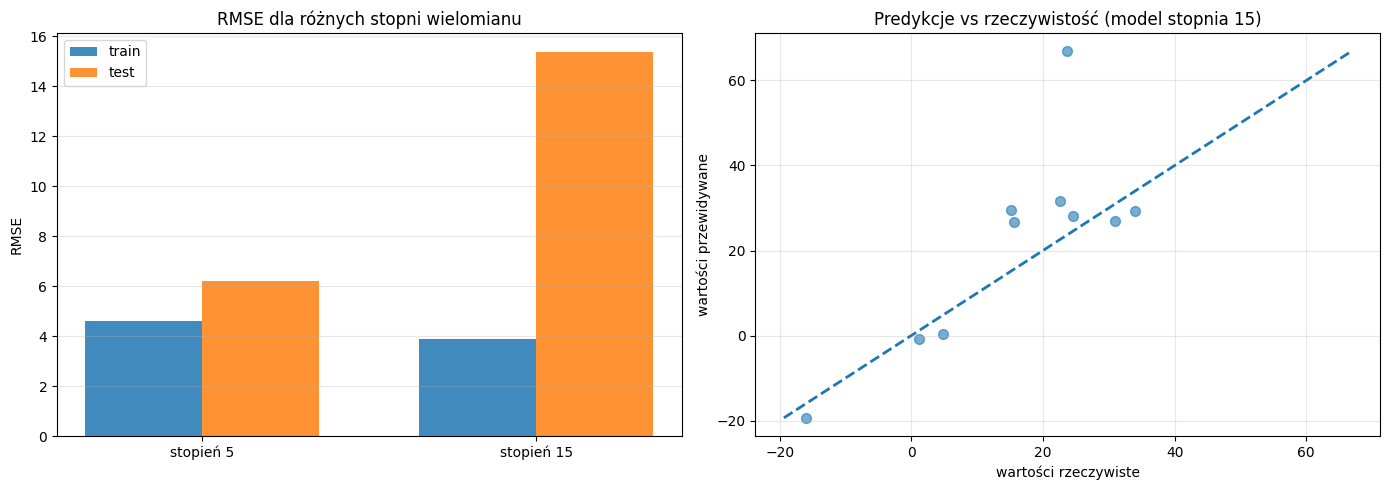

In [ ]:
# Miejsce na potrzebne funkcje

# Funkcja pomocnicza: RMSE
def rmse(y_true, y_pred):
    diff = np.asarray(y_true) - np.asarray(y_pred)
    return np.sqrt(np.mean(diff ** 2))

# Funkcja pomocnicza: macierz cech wielomianowych
def poly_design(x, degree):
    x = np.asarray(x).ravel()
    return np.vander(x, N=degree + 1, increasing=True)


# --- Model stopnia 15 ---

deg_15 = 15
X_tr_15 = poly_design(X_train, deg_15)
X_te_15 = poly_design(X_test, deg_15)

ridge_15 = Ridge(alpha=best_lambda, fit_intercept=False)
ridge_15.fit(X_tr_15, y_train)

y_tr_hat_15 = ridge_15.predict(X_tr_15)
y_te_hat_15 = ridge_15.predict(X_te_15)

rmse_tr_15 = rmse(y_train, y_tr_hat_15)
rmse_te_15 = rmse(y_test, y_te_hat_15)


# --- Model stopnia 5 ---

deg_5 = 5
X_tr_5 = poly_design(X_train, deg_5)
X_te_5 = poly_design(X_test, deg_5)

ridge_5 = Ridge(alpha=best_lambda, fit_intercept=False)
ridge_5.fit(X_tr_5, y_train)

y_tr_hat_5 = ridge_5.predict(X_tr_5)
y_te_hat_5 = ridge_5.predict(X_te_5)

rmse_tr_5 = rmse(Y_train, y_tr_hat_5)
rmse_te_5 = rmse(y_test, y_te_hat_5)


# --- Tabela tekstowa ---


print("PORÓWNANIE MODELI RIDGE")
print("=" * 70)
print(f"{'Metryka':<32} {'stopień 5':<18} {'stopień 15':<18}")
print("-" * 70)
print(f"{'RMSE (train)':<32} {rmse_tr_5:<18.4f} {rmse_tr_15:<18.4f}")
print(f"{'RMSE (test)':<32} {rmse_te_5:<18.4f} {rmse_te_15:<18.4f}")
print(f"{'Δ RMSE test-train (deg 5)':<32} {rmse_te_5 - rmse_tr_5:<18.4f}")
print(f"{'Δ RMSE test-train (deg 15)':<32} {rmse_te_15 - rmse_tr_15:<18.4f}")



# --- Wykresy ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: słupki RMSE
labels = ["stopień 5", "stopień 15"]
train_vals = [rmse_tr_5, rmse_tr_15]
test_vals = [rmse_te_5, rmse_te_15]

pos = np.arange(len(labels))
w = 0.35

axes[0].bar(pos - w/2, train_vals, width=w, label="train",
            alpha=0.85)
axes[0].bar(pos + w/2, test_vals, width=w, label="test",
            alpha=0.85)

axes[0].set_xticks(pos)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel("RMSE")
axes[0].set_title("RMSE dla różnych stopni wielomianu")
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Wykres 2: predykcja vs rzeczywiste (stopień 15)
axes[1].scatter(y_test, y_te_hat_15, alpha=0.6, s=50)
low = min(y_test.min(), y_te_hat_15.min())
high = max(y_test.max(), y_te_hat_15.max())
axes[1].plot([low, high], [low, high], linestyle="--", linewidth=2)

axes[1].set_xlabel("wartości rzeczywiste")
axes[1].set_ylabel("wartości przewidywane")
axes[1].set_title("Predykcje vs rzeczywistość (model stopnia 15)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Zastosowanie regularyzacji ograniczyło rozbieżność między błędem treningowym a testowym w prostszych modelach, co poprawiło ich zdolność do generalizacji. Przy wyższych stopniach wielomianu regularyzacja okazała się zbyt słaba, aby zapobiec przeuczeniu.


Model stopnia 5 uzyskał zdecydowanie lepszy błąd testowy i mniejszą różnicę między RMSE(test) a RMSE(train).
Model stopnia 15 silnie overfituje — mimo niskiego błędu treningowego osiąga dużo gorsze wyniki na zbiorze testowym.

Spośród rozważanych wartości najmniejszy błąd walidacji uzyskano dla λ = 0.01.
Jednak przy modelu stopnia 15 taka regularyzacja nie wystarcza, co potwierdza wysoki błąd testowy — lepsza stabilność występuje przy niższych stopniach wielomianu.

### Zadanie 2 - Metoda doboru cech modelu

Pierwszą metodą doboru cech modelu, która zostanie przetestowana jest metoda zachłanna (algorytm w przód). W każdym kroku tej metody poszukujemy cechy, która najlepiej minimalizuje nam średni błąd CV (walidacji krzyżowej), a następnie dodajemy ją do zbioru cech.   

Do tego celu wykorzystamy zbiór przedstawiający ceny mieszkań z King County (do pobrania z ISODu).

In [22]:
# Wczytanie danych
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

In [23]:
# Stworzenie nowych zmiennych
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

In [25]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
sales_train, sales_test = train_test_split(sales, test_size=0.2, random_state=42)

print(f"Rozmiar zbioru treningowego: {len(sales_train)}")
print(f"Rozmiar zbioru testowego: {len(sales_test)}")


Rozmiar zbioru treningowego: 17290
Rozmiar zbioru testowego: 4323


Na zbiorze treningowym, dla cech 
['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
przy pomocy walidacji krzyżowej wyznaczamy wykresy błąd modelu, który będzie miał tylko wyraz wolny, a następnie biorąc pojedynczą cechę, a następnie wszystkie podwójne, potrójne itd. cechy wyznaczamy błędy modelu. Na podstawie tych błędów wyznaczamy, które zbiory cech (1, 2, 3, ...) elementowe nalepiej minimalizują nam błąd CV. 

In [28]:
# Miejsce na kod
from sklearn.linear_model import LinearRegression
from itertools import combinations

lr = LinearRegression()
features = ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living',
            'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors',
            'floors_square', 'waterfront', 'view', 'condition', 'grade',
            'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

best_features_by_size = {}

# TYLKO ROZMIARY 1–5
for size in range(1, 6):
    best_err = np.inf
    best_set = None

    for combo in combinations(features, size):

        tmp_features = list(combo)
        cv_scores = cross_val_score(
            lr,
            sales[tmp_features],
            sales['price'],
            cv=3,
            scoring='neg_mean_squared_error'
        )

        error = -cv_scores.mean()

        if error < best_err:
            best_err = error
            best_set = tmp_features

    best_features_by_size[size] = (best_set, best_err)
    print(f"Rozmiar {size}: {best_set} -> MSE CV: {best_err:.2e}")

Rozmiar 1: ['sqft_living'] -> MSE CV: 6.84e+10
Rozmiar 2: ['sqft_living', 'view'] -> MSE CV: 6.27e+10
Rozmiar 3: ['sqft_living', 'grade', 'yr_built'] -> MSE CV: 5.40e+10
Rozmiar 4: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built'] -> MSE CV: 4.92e+10
Rozmiar 5: ['sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built'] -> MSE CV: 4.56e+10


Ograniczyłem liczbę analizowanych zestawów cech do maksymalnie pięciu, ponieważ liczba wszystkich możliwych kombinacji rośnie wykładniczo wraz z ich rozmiarem.
Dla sześciu i więcej cech liczba kombinacji staje się bardzo duża, co prowadzi do znaczącego wydłużenia czasu obliczeń.

Następnie wykorzystując powyższe wyniki lub opracowując nową funkcję napisz algorytm zachłanny wyboru cech, który do nowego zbioru cech dorzucać będzie cechę, która najlepiej minimalizuje błąd naszego modelu.

In [29]:
# Miejce na kod
chosen_features = []
candidate_features = features.copy()
mse_history = []

for step in range(len(features)):

    best_mse = np.inf
    best_candidate = None

    # evaluate every unused feature
    for feat in candidate_features:
        trial_set = chosen_features + [feat]

        model = LinearRegression()
        cv_result = cross_val_score(
            model,
            sales_train[trial_set],
            sales_train['price'],
            cv=3,
            scoring="neg_mean_squared_error"
        )

        mse_val = -cv_result.mean()

        if mse_val < best_mse:
            best_mse = mse_val
            best_candidate = feat

    # update lists
    chosen_features.append(best_candidate)
    candidate_features.remove(best_candidate)
    mse_history.append(best_mse)

    print(f"[Step {step+1}] Added feature: {best_candidate}")
    print(f"    Current set: {chosen_features}")
    print(f"    MSE (CV): {best_mse:.2e}\n")

[Step 1] Added feature: sqft_living
    Current set: ['sqft_living']
    MSE (CV): 6.65e+10

[Step 2] Added feature: sqft_living_sqrt
    Current set: ['sqft_living', 'sqft_living_sqrt']
    MSE (CV): 6.04e+10

[Step 3] Added feature: grade
    Current set: ['sqft_living', 'sqft_living_sqrt', 'grade']
    MSE (CV): 5.43e+10

[Step 4] Added feature: yr_built
    Current set: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built']
    MSE (CV): 4.70e+10

[Step 5] Added feature: waterfront
    Current set: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built', 'waterfront']
    MSE (CV): 4.37e+10

[Step 6] Added feature: bathrooms
    Current set: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built', 'waterfront', 'bathrooms']
    MSE (CV): 4.27e+10

[Step 7] Added feature: view
    Current set: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built', 'waterfront', 'bathrooms', 'view']
    MSE (CV): 4.18e+10

[Step 8] Added feature: sqft_lot_sqrt
    Current set: ['sqft_living', 'sq

**Prowównaj jak powyżej otrzymane cechy dla algorytmu zachłannego różnią się od najlepszych zbiorów cech.**

Metody dają podobne zestawy dla małych rozmiarów (1–5 cech), ale już od rozmiaru 2 widać różnice w wyborze kolejnych cech.
Mimo tego MSE obu metod pozostaje w zbliżonym zakresie.


Obie metody zgodnie wskazują sqft_living jako najważniejszą cechę.
Greedy wybiera kolejne cechy w innej kolejności, ale ogólny zestaw jest podobny i obejmuje te same kluczowe predyktory (grade, yr_built, waterfront).

Algorytm zachłanny nie zapewnia optymalnych zestawów, ale osiąga wyniki bliskie pełnemu przeszukaniu.
Jest znacznie szybszy obliczeniowo, dzięki czemu lepiej nadaje się do dużych zbiorów cech.

### Zadanie 3 - Metoda Lasso
W metodzie LASSO (Least Absolute Shrinkage and Selection Operator) wykorzystujemy normę L1 do wygaszenia cech, które nia mają znaczącego wpływu na model. W przypadku tej metody funkcja kosztu C($\omega$) ma następującą postać:

$$C_{lasso}(\omega)=\sum_{i=1}^{n}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{|\omega_j|},$$

W przypadku regularyzacji metodą Lasso dokonuje się normalizacji zmiennych opisujących. 

Poniżej przykładowy kod.

In [31]:

from sklearn import linear_model  # using scikit-learn

all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

model_all = linear_model.Lasso(alpha=5e2) # set parameters #, normalize=True
model_all.fit(sales[all_features], sales['price']) # learn weights

C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+14, tolerance: 2.913e+11
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=500.0)

**Na podstawie wyników powyższego kodu określ, które cechy zostały wybrane przez algorytm.**

Tak samo jak działaliśmy w przypadku regularyzacji grzbietowej, wydziel 20% zbiór testowy, a następnie przy pomocy CV na zbiorze zbiorze uczącym i powyższego kodu, dokonaj doboru współczynnika alpha. Wykreś RMSE oraz współczynniki poszczególnych cech w funkcji zmiany parametru $\lambda$.

C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


alpha=0.5: CV MSE = 4.18e+10


C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.653e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


alpha=1.0: CV MSE = 4.18e+10


C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.656e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


alpha=5.0: CV MSE = 4.18e+10


C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.660e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


alpha=10.0: CV MSE = 4.17e+10


C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.692e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


alpha=50.0: CV MSE = 4.16e+10


C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


alpha=100.0: CV MSE = 4.16e+10


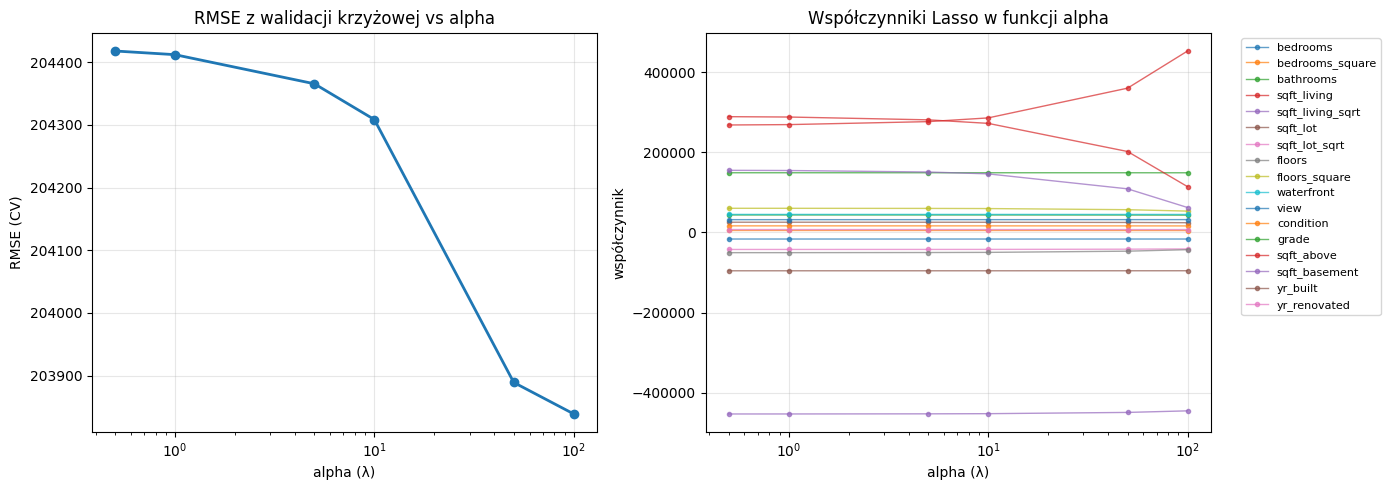


Najlepsza alpha: 100.0
Najlepszy MSE CV: 4.16e+10

Cechy z niezerowymi współczynnikami:
  bedrooms: -16463.7730
  bedrooms_square: 4704.4129
  bathrooms: 43103.2328
  sqft_living: 452607.6956
  sqft_living_sqrt: -445092.7903
  sqft_lot: 24242.6927
  sqft_lot_sqrt: -41125.0764
  floors: -43012.9338
  floors_square: 53202.0920
  waterfront: 44874.2550
  view: 31972.0234
  condition: 16227.9702
  grade: 148783.3738
  sqft_above: 114097.1864
  sqft_basement: 62117.3652
  yr_built: -95594.8519
  yr_renovated: 7062.9639


In [33]:
# Miejsce na kod
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Podział na train / test (20%) – tylko jeśli nie zrobiono tego wcześniej
try:
    sales_train
    sales_test
except NameError:
    sales_train, sales_test = train_test_split(
        sales,
        test_size=0.2,
        random_state=42
    )

# Macierz cech i wektor celu
X_train = sales_train[all_features].values
y_train = sales_train["price"].values

# Standaryzacja cech (Lasso tego potrzebuje)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# Siatka wartości alpha (może być dowolna, tu 6 punktów)
alpha_grid = np.array([0.5, 1.0, 5.0, 10.0, 50.0, 100.0])

cv_mse_lasso = []
coef_path = []

for alpha in alpha_grid:
    lasso = Lasso(alpha=alpha, max_iter=5000, tol=1e-3)

    # MSE z walidacji krzyżowej (zamieniamy znak, bo scoring jest ujemny)
    neg_mse_scores = cross_val_score(
        lasso,
        X_train_std,
        y_train,
        cv=2,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )
    mean_mse = -neg_mse_scores.mean()
    cv_mse_lasso.append(mean_mse)

    # Dopasowanie na całym zbiorze treningowym i zapis współczynników
    lasso.fit(X_train_std, y_train)
    coef_path.append(lasso.coef_)

    print(f"alpha={alpha}: CV MSE = {mean_mse:.2e}")

cv_mse_lasso = np.array(cv_mse_lasso)
coef_path = np.vstack(coef_path)

# --- Wykresy ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) RMSE (√MSE) vs alpha
axes[0].plot(alpha_grid, np.sqrt(cv_mse_lasso), marker="o", linewidth=2)
axes[0].set_xscale("log")
axes[0].set_xlabel("alpha (λ)")
axes[0].set_ylabel("RMSE (CV)")
axes[0].set_title("RMSE z walidacji krzyżowej vs alpha")
axes[0].grid(alpha=0.3)

# 2) Ścieżka współczynników vs alpha
for j, name in enumerate(all_features):
    axes[1].plot(alpha_grid, coef_path[:, j], marker=".", linewidth=1, alpha=0.7, label=name)

axes[1].set_xscale("log")
axes[1].set_xlabel("alpha (λ)")
axes[1].set_ylabel("współczynnik")
axes[1].set_title("Współczynniki Lasso w funkcji alpha")
axes[1].grid(alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

# --- Wybór najlepszej alpha i wypisanie niezerowych cech ---

best_idx = int(np.argmin(cv_mse_lasso))
best_alpha = alpha_grid[best_idx]

print(f"\nNajlepsza alpha: {best_alpha}")
print(f"Najlepszy MSE CV: {cv_mse_lasso[best_idx]:.2e}")

best_coefs = coef_path[best_idx]
print("\nCechy z niezerowymi współczynnikami:")
for name, coef in zip(all_features, best_coefs):
    if coef != 0:
        print(f"  {name}: {coef:.4f}")


**Pytania:**
1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
2. Które z cech, dla ustalonej wartości parametru $\lambda$ wchodzą w skład modelu - podaj w kolejności od najbardziej znaczących cech ?

In [35]:
# Miejsce na kod
# Skalowanie zbioru testowego
X_test_std = scaler.transform(sales_test[all_features])

# Trenowanie modelu Lasso z najlepszym alpha
final_model = Lasso(alpha=best_alpha, max_iter=10000)
final_model.fit(X_train_std, sales_train["price"])

# Predykcje i RMSE na teście
y_test_pred = final_model.predict(X_test_std)
rmse_test = np.sqrt(np.mean((sales_test["price"] - y_test_pred) ** 2))


print(f"1. Wybrana wartość regularizacji α: {best_alpha}")

# Wyciągnięcie współczynników i sortowanie cech wg znaczenia
nonzero_coefs = []
for feat, w in zip(all_features, final_model.coef_):
    if w != 0:
        nonzero_coefs.append((feat, w))

# sortujemy malejąco wg |w|
nonzero_coefs.sort(key=lambda x: abs(x[1]), reverse=True)

print("\n2. Cechy zachowane przez Lasso (posortowane wg ważności):")
for name, weight in nonzero_coefs:
    print(f"   {name}: {weight:.6f}")

print(f"\n3. RMSE na zbiorze testowym: {rmse_test:.2f}")
print(f"4. Liczba wybranych cech: {len(nonzero_coefs)} z {len(all_features)}")

C:\Users\Stasd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1. Wybrana wartość regularizacji α: 100.0

2. Cechy zachowane przez Lasso (posortowane wg ważności):
   sqft_living: 578707.814903
   sqft_living_sqrt: -445083.759920
   grade: 148778.821528
   yr_built: -95605.983730
   floors_square: 53205.657366
   waterfront: 44873.057209
   bathrooms: 43052.455874
   floors: -43010.799621
   sqft_lot_sqrt: -41135.330486
   view: 31970.686949
   sqft_lot: 24243.499742
   bedrooms: -16500.167570
   condition: 16227.312392
   yr_renovated: 7059.633939
   bedrooms_square: 4714.967673
   sqft_basement: 1167.706727

3. RMSE na zbiorze testowym: 222907.73
4. Liczba wybranych cech: 16 z 17


1. Optymalna wartość α to 100, ponieważ daje najniższy błąd walidacji krzyżowej.

2. Lasso zachowuje 16 z 17 cech, z czego najbardziej wpływowa jest sqft_living, a model osiąga RMSE ≈ 222 908 zł na zbiorze testowym.